
### CD8 LCMV  RNA-Velocity (Alevin-scVelo)

    This is RNA-velocity folling Analysis that Zi's  (Agios) performed on the data: 

      1. Zi (Agios) did the pre-processing  and performed clusters definition/anotations,(eg. effector cells, exhausted etc ), performed dimesionality reduction with (UMAP/T-SNE)
            file=/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/agios.code/rstudio-export/RData/LCMV_CD8_integration.procssed_sce_output.Rdata
      
      2. We aim to use extactly the same cells  as Zi's, and annotations.
      
      3. Here at VAI we generated counts for spliced and unspliced for all CD8 sample (using Salomon-Alevin) 
      
            step1:Generate reference fasta files (eisaR) 
            step2:Index the reference features  (Salomon- Alevin)
            step3:Mapping and quatification (Salomon- Alevin): 
                    /secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Step1-2_mapping_quantification_alevin.sh
                    ref:https://combine-lab.github.io/alevin-tutorial/2020/alevin-velocity/
      
      4. We merged counts across sample (and matched bar code with Zi'data) the and computed velocities
      
      5. Zi's has a UMAP coordinates  (with all cells recomputing the UMAP give similar results).
   
    
#### This notebook consist of 4 sections:
    
    Section 1: Merging the counts of spliced and unspliced transcript, with Zi' counts and umap (combined sample)
    Section 2: Mapping cells in individual sample to the combined UMAP
    Section 3: Computing/displaying velocity estimates from the obtained counts (splice / unspliced ) - combined sample
    
    [to be done]
    section 4:  - Identification of cell that drive velocities observed in clusters
                - Computing final/root states, cell fate probability (Cellrank)
                - Speudotime etc.


### Section 1: Merging the counts of splice nd unspliced transcript, with Zi' counts and umap (combined sample)

In [8]:
#import of python modules
import sys
import numpy as np
import anndata
import rpy2
from rpy2.robjects import r
import anndata2ri
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
sys.executable

'/primary/projects/mnp/tools/anaconda3/envs/alevin_env/bin/python3.7'

In [3]:
%%R 
paste0(R.Version()$major,".",R.Version()$minor)

[1] "4.0.0"


In [2]:
%%R 
#Importing R libraries
suppressPackageStartupMessages({
    library(Biostrings)
    library(BSgenome)
    library(eisaR)
    library(GenomicFeatures)
    library(SummarizedExperiment)
    library(tximeta)
    library(rjson)
    library(reticulate)
    library(SingleCellExperiment)
    library(scater)
    library(fishpond)
    library(uwot)
})


In [6]:
%%R 
#  Import individual CD8 abundances (spliced unspliced) into R with tximeta  #
#-------------------------------------------------------------------------------------#

## Load the linked transcriptome generated and read alevin output
samples=c("SI-GA-C2_Arm_CD8_Day8",
          "SI-GA-D2_Arm_CD8_Day15",
          "SI-GA-D1_Arm_CD8_Day25",
          "SI-GA-E2_Cl13_CD8_Day8",
          "SI-GA-F2_Cl13_CD8_Day15",
          "SI-GA-E1_Cl13_CD8_Day35",
          "SI-GA-F1_Cl13_CD8_Day35_PD-L1"
         )

prefixs=sapply(samples,function(s){substring(s,gregexpr(pattern = "_",s)[[1]][1]+1,nchar(s))})

path="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/"

txi_list<-list()
count_list<-list() #just for counting all the transcripts
for (prefix in prefixs){
    for (L in c("L001","L002")){
        sname=paste0(prefix,"_",L)
        outPath=paste0(path,sname,"_alevin_out/alevin/quants_mat.gz")
        cat(sname,"\n")
        cat(outPath,"\n")
        
        tximeta::loadLinkedTxome("gencode.vM24.annotation.expanded.json")
        
        #reading the counts (alevin counts)
        txi <- tximeta::tximeta(coldata = data.frame(names = sname,files = outPath, stringsAsFactors = FALSE), type = "alevin")
        count_list[[sname]]<-txi #just for counting all the transcripts
       
        #split the txi object into unspliced and splice counts
        cg <- read.delim("gencode.vM24.annotation.expanded.features.tsv",header = TRUE, as.is = TRUE)
        # Rename the 'intron' column 'unspliced' to make assay names compatible with scVelo
        colnames(cg)[colnames(cg) == "intron"] <- "unspliced"
        txis <- tximeta::splitSE(txi, cg, assayName = "counts")
        
        txi_list[[sname]]<-txis
            
    }
}

Arm_CD8_Day8_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day8_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Arm_CD8_Day8_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day8_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Arm_CD8_Day15_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day15_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Arm_CD8_Day15_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day15_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Arm_CD8_Day25_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day25_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Arm_CD8_Day25_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day25_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day8_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day8_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day8_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day8_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day15_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day15_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day15_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day15_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day35_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day35_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day35_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day35_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day35_PD-L1_L001 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day35_PD-L1_L001_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



Cl13_CD8_Day35_PD-L1_L002 
/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Cl13_CD8_Day35_PD-L1_L002_alevin_out/alevin/quants_mat.gz 


R[write to console]: linkedTxome is same as already in bfc

R[write to console]: importing quantifications

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: found matching linked transcriptome:
[ GENCODE - Mus musculus - release M24 ]

R[write to console]: loading existing TxDb created: 2020-05-12 02:22:57

R[write to console]: generating gene ranges

R[write to console]: loading existing gene ranges created: 2020-05-12 02:23:05

R[write to console]: fetching genome info for GENCODE



In [ ]:
%%R
## Print total counts obtained by Salmon - Alevin and spliced Spliced and Unspliced
#txi_list
#count_list

for (prefix in prefixs){
    sname_L1=paste0(prefix,"_L001")
    sname_L2=paste0(prefix,"_L002")
    cat(prefix,"\n")
    
    spliced1=sum(assay(txi_list[[sname_L1]],"spliced"))
    spliced2=sum(assay(txi_list[[sname_L2]],"spliced"))
    unspliced1=sum(assay(txi_list[[sname_L1]],"unspliced"))
    unspliced2=sum(assay(txi_list[[sname_L2]],"unspliced"))
    counts1=sum(assay(count_list[[sname_L1]],"counts"))
    counts2=sum(assay(count_list[[sname_L2]],"counts"))
    
    spliced_=spliced1+spliced2
    unspliced_=unspliced1+unspliced2
    counts_=counts1+counts2
    
    cat(paste0("spliced ",spliced_,"\t\t",round(spliced_/counts_,2),"\n"))
    cat(paste0("unspliced ",unspliced_,"\t\t",round(unspliced_/counts_,2),"\n"))
    cat(paste0("total counts ",counts_,"\n\n"))
}


In [7]:
%%R
#Checking Aleven counts numbers  (this can be skipped)
 library(tximport)
 p<-"/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/Arm_CD8_Day8_L002_alevin_out/alevin/quants_mat.gz"
 datax=tximport( files=p,type="alevin")
 ix=which(datax$counts>0)
 datax$counts[ix[1:100]]

R[write to console]: reading in alevin gene-level counts across cells with fishpond

R[write to console]: Error in x$.self$finalize() : attempt to apply non-function

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: multiple methods tables found for ‘which’ 



  [1]  0.20000000  1.50000000  2.00000000  1.00000000  3.00000000  0.50000000
  [7]  1.00000000  1.00000000  1.00000000  1.00000000  1.00000000  1.00000000
 [13]  1.00000000  1.00000000  1.00000000  1.00000000  1.00000000  1.00000000
 [19]  1.00000000  0.02777778  1.00000000  2.00000000  2.00000000  0.50000000
 [25]  1.00000000  1.00000000  2.00000000  1.00000000  1.00000000  1.00000000
 [31]  2.00000000  1.00000000  0.20000000  1.00000000  0.50000000  1.00000000
 [37]  1.00000000  1.00000000  2.67274547  0.02777778  6.00000000  1.00000000
 [43]  1.00000000  1.00000000  0.02777778  1.00000000  0.02777778  1.00000000
 [49]  0.50000000  1.50000000  1.00000000  0.50000000  0.50000000  1.00000000
 [55]  1.00000000  1.00000000  1.00000000  1.00000000  9.00000000  1.00000000
 [61]  1.00000000  0.02777778  0.20000000  2.00000000  1.00000000  1.00000000
 [67]  0.02777778  1.00000000  2.00000000 16.46178436  0.25000000  0.25000000
 [73]  0.25000000  1.00000000  1.00000000  0.50000000  1.0000000

In [8]:
%%R

## Convert all txis objects to a SingleCellExperiment object
txi_list_sce<-list()
for (txi in names(txi_list)){
    txi_list_sce[[txi]] <- as(txi_list[[txi]], "SingleCellExperiment")
    cat(txi,"\n")
}


Arm_CD8_Day8_L001 
Arm_CD8_Day8_L002 
Arm_CD8_Day15_L001 
Arm_CD8_Day15_L002 
Arm_CD8_Day25_L001 
Arm_CD8_Day25_L002 
Cl13_CD8_Day8_L001 
Cl13_CD8_Day8_L002 
Cl13_CD8_Day15_L001 
Cl13_CD8_Day15_L002 
Cl13_CD8_Day35_L001 
Cl13_CD8_Day35_L002 
Cl13_CD8_Day35_PD-L1_L001 
Cl13_CD8_Day35_PD-L1_L002 


In [9]:
%%R

## Merging Lanes: 
## Merging generate counts matrices of spliced/unspliced

str(names(txi_list_sce)) #show merged cell= barcodes per sample

names=unique(sapply(names(txi_list_sce),function(n){strsplit(n,"_L00")[[1]][1]}))

spliced_M_list=list()
unspliced_M_list=list()

for (n in names){
    cat(n,"\n")
    n1=paste0(n,"_L001")
    n2=paste0(n,"_L002")
    
    # merging spliced count matrices for L001, L002
    s1=assay(txi_list_sce[[n1]],"spliced")
    s2=assay(txi_list_sce[[n2]],"spliced")
    si=intersect(colnames(s1),colnames(s2));str(si)  ### matching cell barcodes    
    spliced_M_list[[n]]<-s1[,si]+ s2[,si]            ### summing upp
    
    # merging unspliced count matrices L001, L002
    u1=assay(txi_list_sce[[n1]],"unspliced")
    u2=assay(txi_list_sce[[n2]],"unspliced")
    ui=intersect(colnames(u1),colnames(u2));str(ui)  ### matching cell barcodes  
    unspliced_M_list[[n]]<-u1[,ui]+u2[,ui]           ### summing up   
}

save(spliced_M_list,unspliced_M_list,file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_individual_alevin_spliced_unspliced_matx.RData")


 chr [1:14] "Arm_CD8_Day8_L001" "Arm_CD8_Day8_L002" "Arm_CD8_Day15_L001" ...
Arm_CD8_Day8 
 chr [1:5845] "TTTGCGCGTCAATGTC" "TGAGCCGCAGTATGCT" "ACCGTAACAAACAACA" ...
 chr [1:5845] "TTTGCGCGTCAATGTC" "TGAGCCGCAGTATGCT" "ACCGTAACAAACAACA" ...
Arm_CD8_Day15 
 chr [1:7191] "CTGGTCTGTCTTGCGC" "CATCGAACAGGACGTA" "AGAGCGATCTCCAGGG" ...
 chr [1:7191] "CTGGTCTGTCTTGCGC" "CATCGAACAGGACGTA" "AGAGCGATCTCCAGGG" ...
Arm_CD8_Day25 
 chr [1:7813] "CTGGTCTGTCTTGCGC" "GCTGCGGATATGGGTA" "GCTTGAAGTATGCTTG" ...
 chr [1:7813] "CTGGTCTGTCTTGCGC" "GCTGCGGATATGGGTA" "GCTTGAAGTATGCTTG" ...
Cl13_CD8_Day8 
 chr [1:3627] "ATAGACCCAGACAAAT" "GGCTGGTTCCCAACGG" "CAAGTTGTCTTGGGTA" ...
 chr [1:3627] "ATAGACCCAGACAAAT" "GGCTGGTTCCCAACGG" "CAAGTTGTCTTGGGTA" ...
Cl13_CD8_Day15 
 chr [1:6423] "GAACCTATCGTCTGCT" "TTCTACAAGAGGGCTT" "TCTGAGACAGTAAGCG" ...
 chr [1:6423] "GAACCTATCGTCTGCT" "TTCTACAAGAGGGCTT" "TCTGAGACAGTAAGCG" ...
Cl13_CD8_Day35 
 chr [1:7632] "GCTGCGGATATGGGTA" "CTGGTCTGTCTTGCGC" "CGCTATCCAGCTGCTG" ...
 chr [1

In [10]:
%%R

## Renaming cell barcodes (in splice/unspliced matrices) as in Zi's Seurat Object: adding a suffix (representing sample name) for each of the seven samples: _1, _2 ..., _7
## This is done to match barcode with Zi;s

load(file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_individual_alevin_spliced_unspliced_matx.RData")

i=1
for (nam in names(spliced_M_list)){
    mat=spliced_M_list[[nam]]
    colnames(mat)=unlist(lapply(colnames(mat),function(n){paste0(n,"_",i)}))
    spliced_M_list[[nam]]=mat
    i=i+1
}
i=1
for (nam in names(unspliced_M_list)){
    mat=unspliced_M_list[[nam]]
    colnames(mat)=unlist(lapply(colnames(mat),function(n){paste0(n,"_",i)}))
    unspliced_M_list[[nam]]=mat
    i=i+1
}

In [11]:
%%R

## Merging colunms of splice for all samples
## Merging colunms of unspliced for all samples

spliced_=do.call(cbind,spliced_M_list)
unspliced_=do.call(cbind,unspliced_M_list)
cat(paste0("spliced Mat columns: ",paste(dim(spliced_),collapse=".x."),"\n"))
cat(paste0("unspliced Mat columns: ", paste(dim(unspliced_),collapse=".x."),"\n\n"))

#printing the counts
cat(paste0("spliced\t\t:",sum(spliced_),"\n"))
cat(paste0("unspliced\t:",sum(unspliced_),"\n"))
cat(paste0("spl + unspl\t:",sum(spliced_)+sum(unspliced_),"\n"))


spliced Mat columns: 54448.x.46421
unspliced Mat columns: 54448.x.46421

spliced		:27664670.1207524
unspliced	:79785848.9046744
spl + unspl	:107450519.025427


In [12]:
%%R
## Reading Zi's CD8 combined Seurat Object
file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/agios.code/rstudio-export/RData/LCMV_CD8_integration.procssed_sce_output.Rdata"
load(file)

#Print the dimention of counts matrix
cat(paste0("Genes\t:\t",dim(CD8_combined_sce_Zi)[1],",\tCells\t:\t",dim(CD8_combined_sce_Zi)[2],"\n"))
table(CD8_combined_sce_Zi@colData$orig.ident)
cat(paste0("Total count Zi : ",sum(assay(CD8_combined_sce_Zi,"counts")),"\n"))

Genes	:	31053,	Cells	:	39794
Total count Zi : 167816361


In [17]:
%%R
## Match the cell-barcodes between our combined splice/unspliced matrices and the sce combined counts from Zi

intr=intersect(colnames(spliced_),CD8_combined_sce_Zi@colData@rownames); str(intr)
spliced_M=spliced_[,intr]
unspliced_M=unspliced_[,intr]
CD8_combined_sce_Zi=CD8_combined_sce_Zi[,intr]

 chr [1:39773] "TGAGCCGCAGTATGCT_1" "ACCTTTACACCCATGG_1" ...


In [18]:
%%R
## Number of genes and cells in our dataset and Zi's data set
sum(table(CD8_combined_sce_Zi@colData$orig.ident))
cat(dim(spliced_M),"\n") 
cat(dim(unspliced_M),"\n")
cat(dim(CD8_combined_sce_Zi),"\n")

54448 39773 
54448 39773 
31053 39773 


In [19]:
%%R
## Chenging from Ensembl ids to gene symbol, removal of duplicated gene names and matching with Zi's gene list (31,053)
## Ens ID to gene symbols ( Method 2)
load("/primary/projects/mnp/tools/cellranger-3.0.2/refdata-cellranger-mm10-3.0.0/genes/genes_ENS_NAME_DF.RData")

ensembl_ids <- as.character(sapply(rownames(spliced_M),function(id){strsplit(id,"\\.")[[1]][1]}))

ix=match(ensembl_ids,DF$ens_id)
                                   
xi=DF$ens_id[ix[!is.na(ix)]]
xn=DF$name[ix[!is.na(ix)]]                                  

In [20]:
%%R
#removing duplicated gene names
xi=xi[!duplicated(xn)]
xn=xn[!duplicated(xn)]
str(xi)
str(xn)

 chr [1:30436] "ENSMUSG00000089699" "ENSMUSG00000025903" ...
 chr [1:30436] "Gm1992" "Lypla1" "Gm37988" "Tcea1" "Gm16041" "Atp6v1h" ...


In [21]:
%%R
#str(xn)
str(setdiff(xn,rownames(spliced_M)))

 chr [1:30436] "Gm1992" "Lypla1" "Gm37988" "Tcea1" "Gm16041" "Atp6v1h" ...


In [22]:
%%R
#subsetting in the matrices ( Method 2)
rownames(spliced_M)<-rownames(unspliced_M)<-ensembl_ids
spliced_M=spliced_M[xi,]
unspliced_M=unspliced_M[xi,]
rownames(spliced_M)<-rownames(unspliced_M)<-xn

In [23]:
%%R
## Matching the gene names of splice/unspliced counter to those of Zi'sce object
intr=intersect(rownames(unspliced_M),rownames(CD8_combined_sce_Zi))
spliced_M=spliced_M[intr,]
unspliced_M=unspliced_M[intr,]
CD8_combined_sce_Zi=CD8_combined_sce_Zi[intr,]

In [24]:
%%R
## View of matrices for spliced/unsplice/counts(by Zi) 
cat(dim(spliced_M),"\n")
cat(dim(unspliced_M),"\n")
cat(dim(assay(CD8_combined_sce_Zi,"counts")),"\n")

cat(paste0("Z's tot counts :",sum(assay(CD8_combined_sce_Zi,"counts")),"\n\n"))

str(spliced_M)
str(unspliced_M)
str(assay(CD8_combined_sce_Zi,"counts"))


30436 39773 
30436 39773 
30436 39773 
Z's tot counts :167649104

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:5459152] 101 183 327 711 790 866 958 987 1055 1064 ...
  ..@ p       : int [1:39774] 0 276 771 1065 1339 2220 2489 2867 2988 3239 ...
  ..@ Dim     : int [1:2] 30436 39773
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:30436] "Gm1992" "Lypla1" "Gm37988" "Tcea1" ...
  .. ..$ : chr [1:39773] "TGAGCCGCAGTATGCT_1" "ACCTTTACACCCATGG_1" "AACTCAGTCTGCCCTA_1" "TGCCCATTCAACACAC_1" ...
  ..@ x       : num [1:5459152] 2 1 1 4 2 1 2 2 1 1 ...
  ..@ factors : list()
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:14143443] 2 16 21 42 143 170 184 341 494 504 ...
  ..@ p       : int [1:39774] 0 464 1179 1780 2310 3323 3950 4566 4884 5450 ...
  ..@ Dim     : int [1:2] 30436 39773
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:30436] "Gm1992" "Lypla1" "Gm37988" "Tcea1" ...
  .. ..$ : chr [1:39773] "TGAGCCGCAGTATGCT_1" "ACCTTTACACCCATGG

In [25]:
%%R
#Show the number of transcripts
cat(paste0("spliced\t\t\t:\t",sum(spliced_M)))
cat(paste0("\nunspliced\t\t:\t",sum(unspliced_M)))
cat(paste0("\nspliced+unspliced\t:\t",sum(spliced_M)+sum(unspliced_M)))
cat(paste0("\nZi's counts\t\t:\t",sum(assay(CD8_combined_sce_Zi, "counts"))))

spliced			:	12765188.1316841
unspliced		:	72863495.9740643
spliced+unspliced	:	85628684.1057483
Zi's counts		:	167649104

In [48]:
%%R
##Make a new sce experiment data structure with counts/logcounts (from Zi) and compute splice/unspliced counts, plus Zi's UMAP 
tmp_sce=CD8_combined_sce_Zi
assays(tmp_sce)=list(counts=assay(tmp_sce, "counts"),logcounts=assay(tmp_sce, "logcounts"),spliced=spliced_M, unspliced=unspliced_M)
names(assays(tmp_sce))


[1] "counts"    "logcounts" "spliced"   "unspliced"


In [55]:
%%R
## add a factor of sample names [to avoid ploting errors in scvelo]
tmp_sce@colData$orig.identF=as.factor(tmp_sce@colData$orig.ident)
str(tmp_sce@colData)

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:39773] "TGAGCCGCAGTATGCT_1" "ACCTTTACACCCATGG_1" "AACTCAGTCTGCCCTA_1" "TGCCCATTCAACACAC_1" ...
  ..@ nrows          : int 39773
  ..@ listData       :List of 15
  .. ..$ orig.ident            : chr [1:39773] "Arm-CD8-Day8" "Arm-CD8-Day8" "Arm-CD8-Day8" "Arm-CD8-Day8" ...
  .. ..$ nCount_RNA            : num [1:39773] 24937 20708 20582 17711 15093 ...
  .. ..$ nFeature_RNA          : int [1:39773] 3761 3894 3656 3578 3625 3682 3725 2144 3559 3746 ...
  .. ..$ percent.mt            : num [1:39773] 0.229 2.54 2.06 2.75 3.101 ...
  .. ..$ housekeeping_gene     : num [1:39773] 2.83 2.44 2.9 2.73 2.45 ...
  .. ..$ nCount_RNA.log2       : num [1:39773] 14.6 14.3 14.3 14.1 13.9 ...
  .. ..$ outlier               : logi [1:39773] FALSE FALSE FALSE FALSE FALSE FALSE ...
  .. ..$ S.Score               : num [1:39773] 0.4743 0.3006 0.196 0.1518 -0.0559 ...
  .. ..$ G2M.Score             : num [1:39773] 0.257 0.8

In [61]:
%%R
#Save the sce object containing Zi's counts and logcounts matrices (with umap,pca,metadata), plus our alevin spliced and unspliced matrices
save(tmp_sce,file="/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_combined_counts_logcounts_alevin_spliced_unspliced_sce.RData")




### Section 2: Mapping cells in individual sample the the combined UMAP 





In [1]:

#import of python modules
import sys
import scanpy as sc
import numpy as np
import anndata
import rpy2
from rpy2.robjects import r
import anndata2ri
anndata2ri.activate()

%load_ext rpy2.ipython


In [2]:
%%R
#import R libraries
suppressPackageStartupMessages(
    {library(scran)
     library(Rtsne)
     library(scater)
     library(dittoSeq)
    })
#Load the generated sce object
load("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_combined_counts_logcounts_alevin_spliced_unspliced_sce.RData")

In [3]:
%%R
# Adding the refined clusters (By Zi Agios)
tb=read.csv("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/200401_Rusty_LCMV_CD8_Seurat_clusters.tsv",sep="\t")
head(tb)
barcodes=tb[,"barcode"]
ix=match(colnames(tmp_sce),barcodes)
tmp_sce$seurat_clusters_refined=as.factor(tb$seurat_cluster[ix])
cat('Original clusters')
print(table(tmp_sce$seurat_clusters))
cat('\nRefined clusters')
print(table(tmp_sce$seurat_clusters_refined))

Original clusters
    0     1    10    11    12    13    14    15    16     2     3     4     5 
11081  7374   614   392   351   333   317   202   148  6497  4185  2314  1721 
    6     7     8     9 
 1223  1101  1070   850 

Refined clusters
    0   1.1   1.2     2     3     4   5.1   5.2     6   7.1   7.2     8     9 
11081  4534  2941  6136  4185  2314  1340   410  1229   629   483  1073   850 
   10  11.1  11.2    12    13    14    15    16 
  614   305    89   557   333   320   202   148 


In [5]:
%%R
# Add factor that shows clusters for individual sample and replacing NAs for other samples names
# Use to visualize each individual group

sampleN_vect=as.character(tmp_sce$orig.identF)
sample_Names=(names(table(sampleN_vect)))
seurat_clusters_refined=as.character(tmp_sce$seurat_clusters_refined)

for (sN in sample_Names){

    ixNA=(which(sampleN_vect!=sN))
    
    s1<-sampleN_vect
    s2 <- seurat_clusters_refined
    
    s1[ixNA]=NA
    s2[ixNA]=NA
    
    ## Highliting all individual samples on the Unified UMAP
    
    tmp_sce[[paste0(sN,"_Lbl")]]=as.factor(s1)
    tmp_sce[[paste0(sN,"_seurat_cluster_refined")]]=as.factor(s2)
}


In [6]:
adata = r('as(tmp_sce, "SingleCellExperiment")')
adata

AnnData object with n_obs × n_vars = 39773 × 30436
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'housekeeping_gene', 'nCount_RNA.log2', 'outlier', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.5', 'ident', 'orig.identF', 'seurat_clusters_refined', 'Arm-CD8-Day15_Lbl', 'Arm-CD8-Day15_seurat_cluster_refined', 'Arm-CD8-Day35_Lbl', 'Arm-CD8-Day35_seurat_cluster_refined', 'Arm-CD8-Day8_Lbl', 'Arm-CD8-Day8_seurat_cluster_refined', 'Cl13-CD8-Day15_Lbl', 'Cl13-CD8-Day15_seurat_cluster_refined', 'Cl13-CD8-Day35_Lbl', 'Cl13-CD8-Day35_seurat_cluster_refined', 'Cl13-CD8-Day35-PD-L1_Lbl', 'Cl13-CD8-Day35-PD-L1_seurat_cluster_refined', 'Cl13-CD8-Day8_Lbl', 'Cl13-CD8-Day8_seurat_cluster_refined'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    layers: 'logcounts', 'spliced', 'unspliced'

--

    UMAP showing cells from all samples highiliting all refined clusters

... storing 'orig.ident' as categorical
... storing 'Phase' as categorical
... storing 'RNA_snn_res.0.5' as categorical


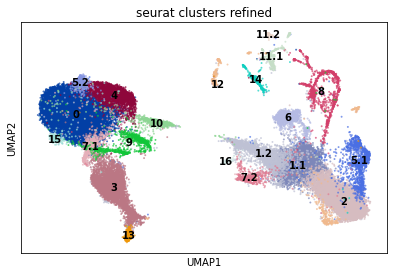

In [7]:
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="seurat_clusters_refined",legend_loc='on data',save="AllCD8_seurat_clusters_refined.svg")

--

    UMAP showing cells from each individual sample highiliting all refined clusters    
    still have problems trying to maintain colors consistant

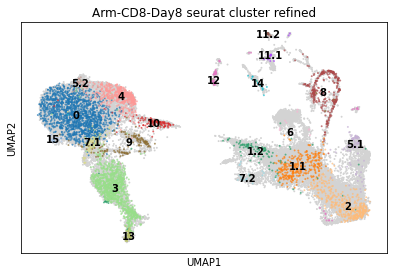

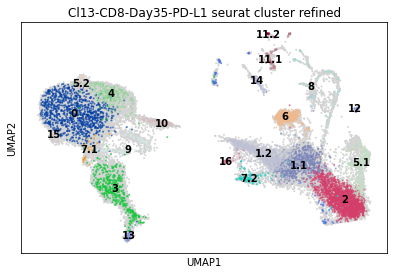

In [8]:
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Arm-CD8-Day8_seurat_cluster_refined",legend_loc='on data',save="Arm-CD8-Day8_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Arm-CD8-Day15_seurat_cluster_refined",legend_loc='on data',save="Arm-CD8-Day15_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Arm-CD8-Day35_seurat_cluster_refined",legend_loc='on data',save="Arm-CD8-Day35_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day8_seurat_cluster_refined",legend_loc='on data',save="Cl13-CD8-Day8_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day15_seurat_cluster_refined",legend_loc='on data',save="Cl13-CD8-Day15_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day35_seurat_cluster_refined",legend_loc='on data',save="Cl13-CD8-Day35_seurat_cluster_refined.svg")
sc.pl.scatter(adata,basis="umap",size=15, alpha=0.7,color="Cl13-CD8-Day35-PD-L1_seurat_cluster_refined",legend_loc='on data',save="Cl13-CD8-Day35-PD-L1_seurat_cluster_refined.svg")

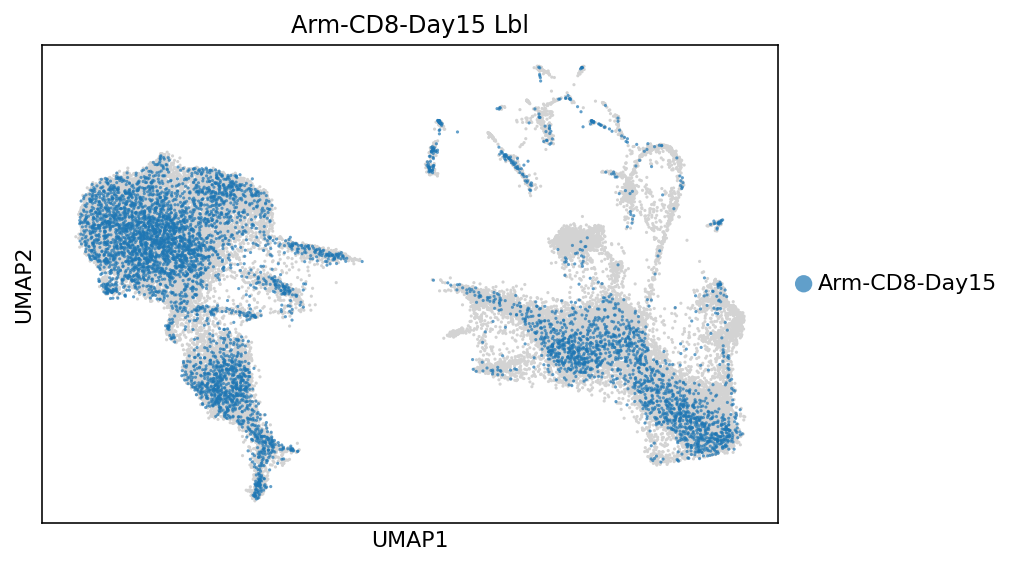

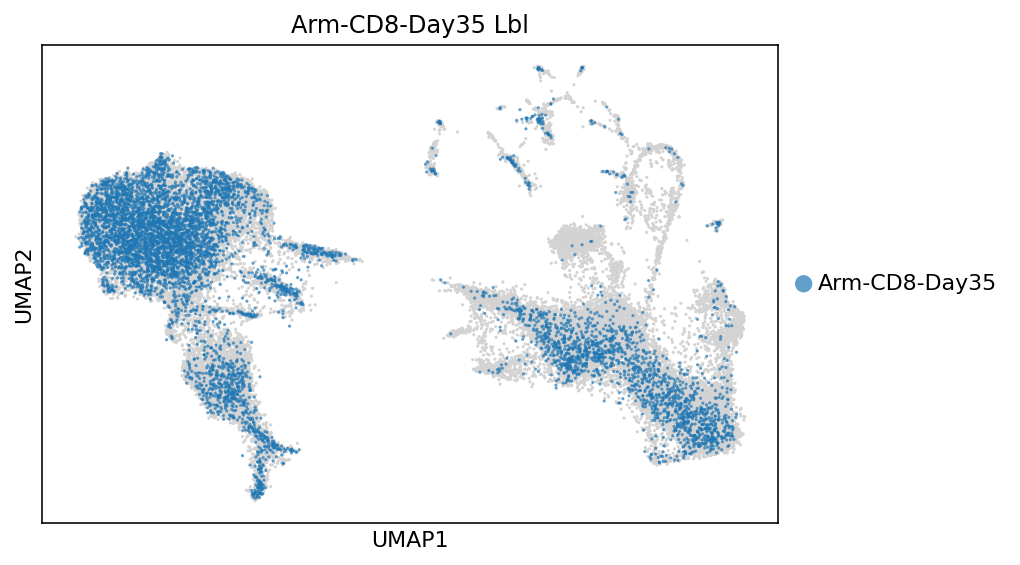

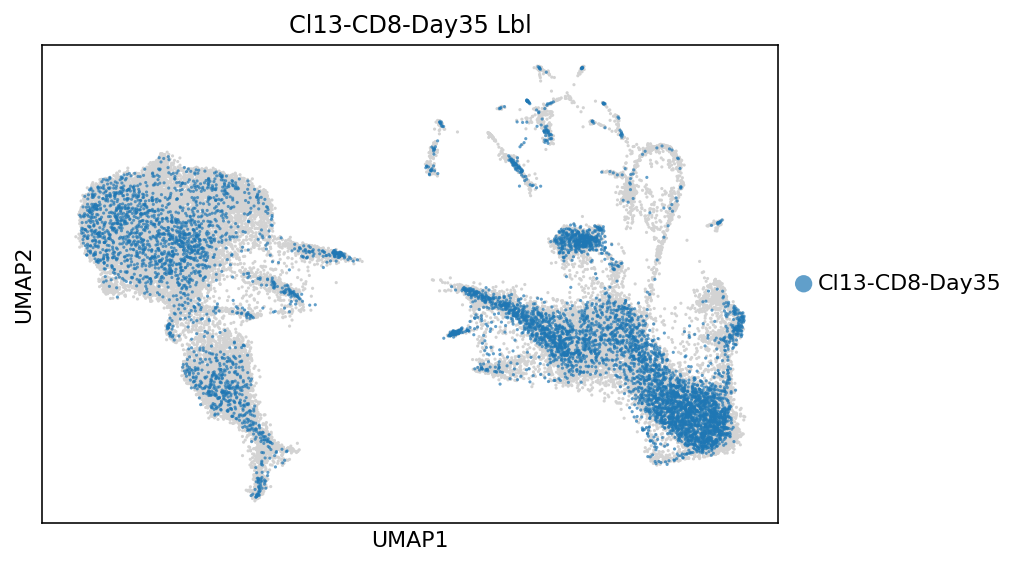

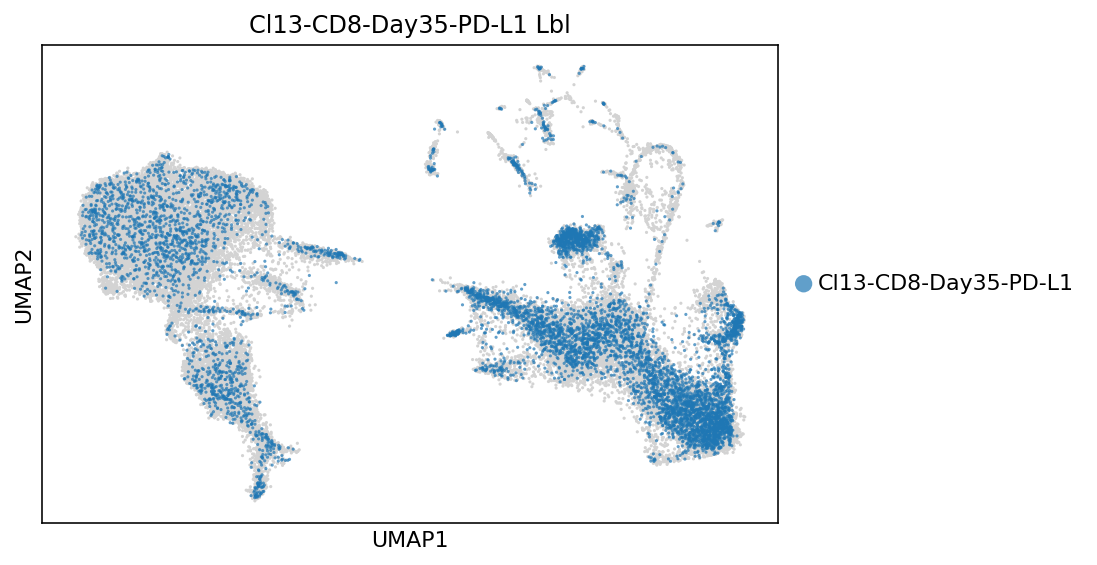

In [140]:
sc.pl.scatter(adata,basis="umap",color ="Arm-CD8-Day8_Lbl",size=10, alpha=0.7,save="Arm-CD8-Day8_Lbl.svg")
sc.pl.scatter(adata,basis="umap",color ="Arm-CD8-Day15_Lbl",size=10, alpha=0.7,save="Arm-CD8-Day15_Lbl.svg")
sc.pl.scatter(adata,basis="umap",color ="Arm-CD8-Day35_Lbl",size=10, alpha=0.7,save="Arm-CD8-Day35_Lbl.svg")
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day8_Lbl",size=10, alpha=0.7,save="Cl13-CD8-Day8_Lbl.svg")
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day15_Lbl",size=10, alpha=0.7,save="Cl13-CD8-Day15_Lbl.svg")
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day35_Lbl",size=10, alpha=0.7,save="Cl13-CD8-Day35_Lbl.svg")
sc.pl.scatter(adata,basis="umap",color ="Cl13-CD8-Day35-PD-L1_Lbl",size=10, alpha=0.7,save="Cl13-CD8-Day35-PD-L1_Lbl.svg")



### Section 3:  Computing velocity vectors from the  obtained counts (splice / unspliced ) - combined sample

In [9]:
#Using scVelo to select variable genes
import scvelo as scv
import matplotlib
import pandas as pd

matplotlib.use('AGG')
scv.logging.print_version()
scv.settings.set_figure_params('scvelo')  # for beautified visualization
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
%matplotlib inline


Running scvelo 0.2.2 (python 3.7.7) on 2020-08-13 16:01.


In [10]:
## Showing lovation of cell from each individual samples



In [11]:
scv.utils.show_proportions(adata)

Abundance of ['spliced', 'unspliced']: [0.15 0.85]


In [12]:
## Percentage of spliced/unspliced transcripts by samples
%matplotlib inline
scv.pl.proportions(adata,groupby='orig.identF',dpi=120,fontsize=8)


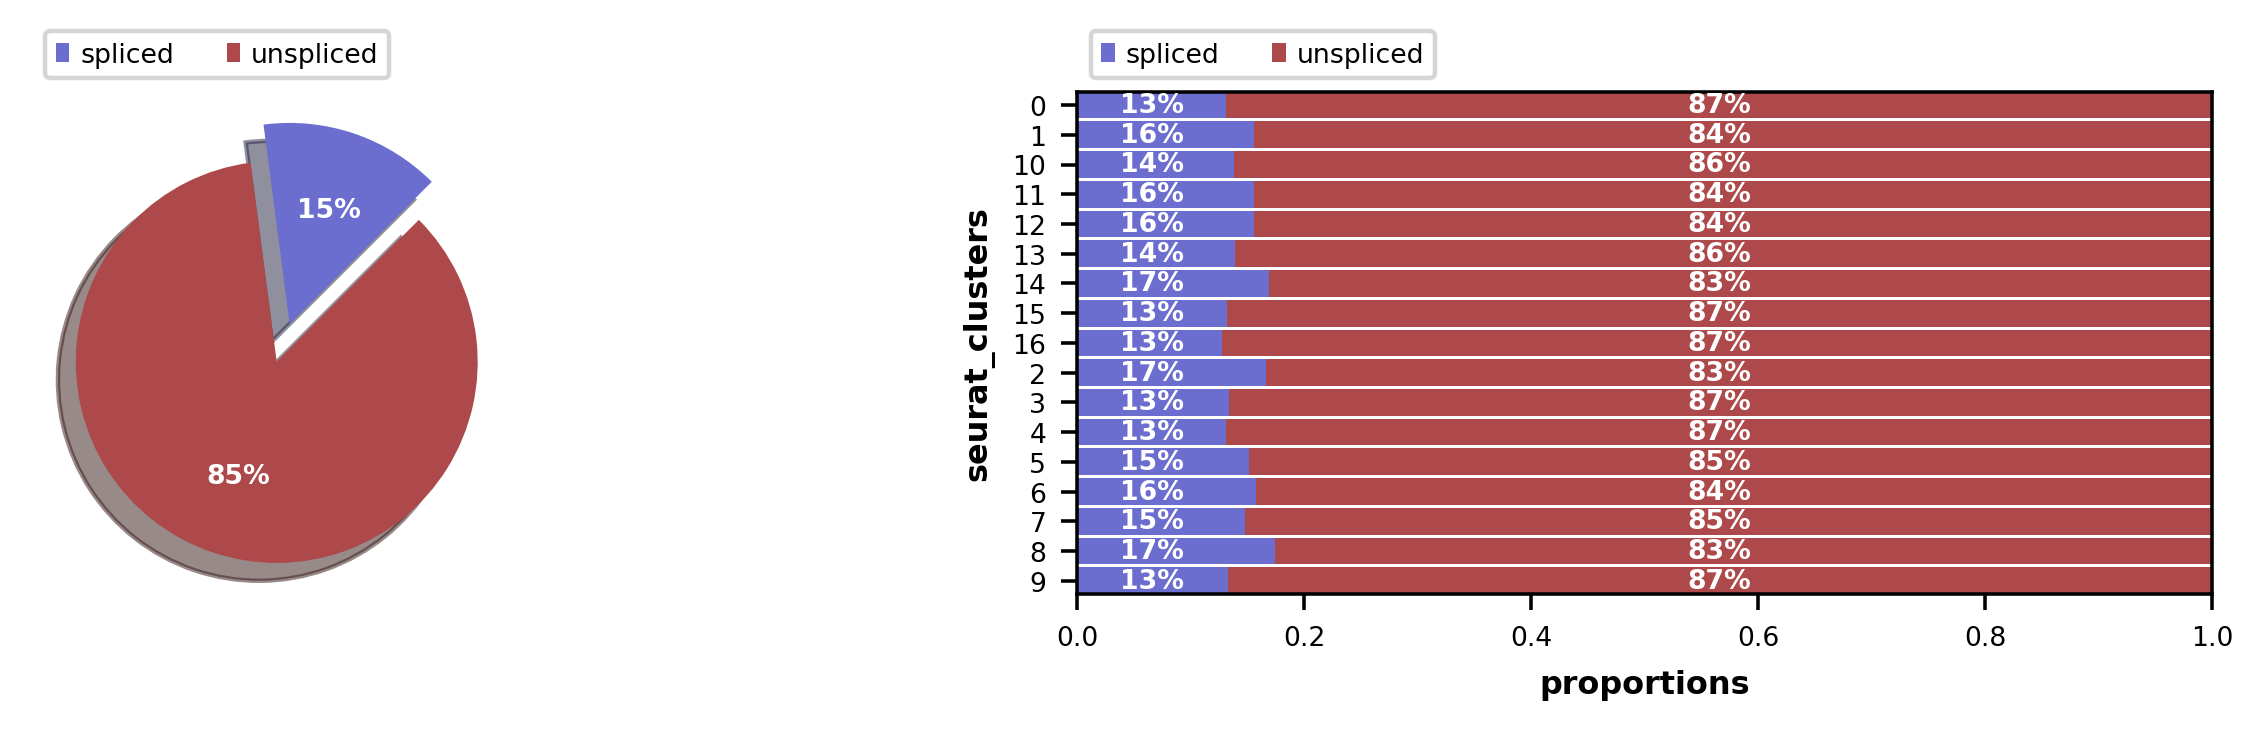

In [13]:
## Percentage of spliced/unspliced transcripts per clusters
scv.pl.proportions(adata,groupby='seurat_clusters',dpi=160,fontsize=6)

In [14]:
## Gene filtering by Minimum number of counts (both unspliced and spliced) required for a gene set to 20.
scv.pp.filter_genes(adata, min_shared_counts = 30)

Filtered out 23387 genes that are detected 30 counts (shared).


In [15]:
## Normalize each cell by total counts over all genes. (library size normalization)
scv.pp.normalize_per_cell(adata, enforce = True)

Normalized count data: X, spliced, unspliced.


In [16]:
#Extracting  highly variable genes. 
#Log-scale the matrices : log(𝑋 + 1), where log denotes the natural logarithm.
#Computes moments for velocity estimation. First- and second-order moments are computed for each cell across its nearest neighbors, where the neighbor
   #graph is obtained from euclidean distances in PCA space.
    
scv.pp.filter_genes_dispersion(adata, n_top_genes = 2000)
scv.pp.log1p(adata)
scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:27) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [17]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:22:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [18]:
## Estimating velocities in a gene-specific manner.

scv.tl.velocity(adata, mode = 'dynamical')

computing velocities
    finished (0:00:23) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [19]:
## Computing velocity graph based on cosine similarities.
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
#%%R

# Generate a list of ggplot2 default colors, for the 17 clusters detected by Zi. (Not used any more)

#* The default colour scheme, scale_colour_hue picks evenly spaced hues around the hcl colour wheel. 
#* With a bit of reverse engineering you can construct this function:
#
#library(ggplot2)
#ggplotColours <- function(n = 6, h = c(0, 360) + 15){
#        if ((diff(h) %% 360) < 1) h[2] <- h[2] - 360/n
#        hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
#}
#ggplot_colz=ggplotColours(n = 17)
#barplot(1:17,col=ggplot_colz)

In [16]:

# Replaced scvelo colors with ggplot2    #(not used anymore)
#scvelo_clz=adata.uns["seurat_clusters_colors"]
#ggplot_clz=r('ggplot_colz')
#adata.uns["seurat_clusters_colors"]=ggplot_clz

saving figure to file ./figures/scvelo_Velocity_stream_allCD8_samples.svg


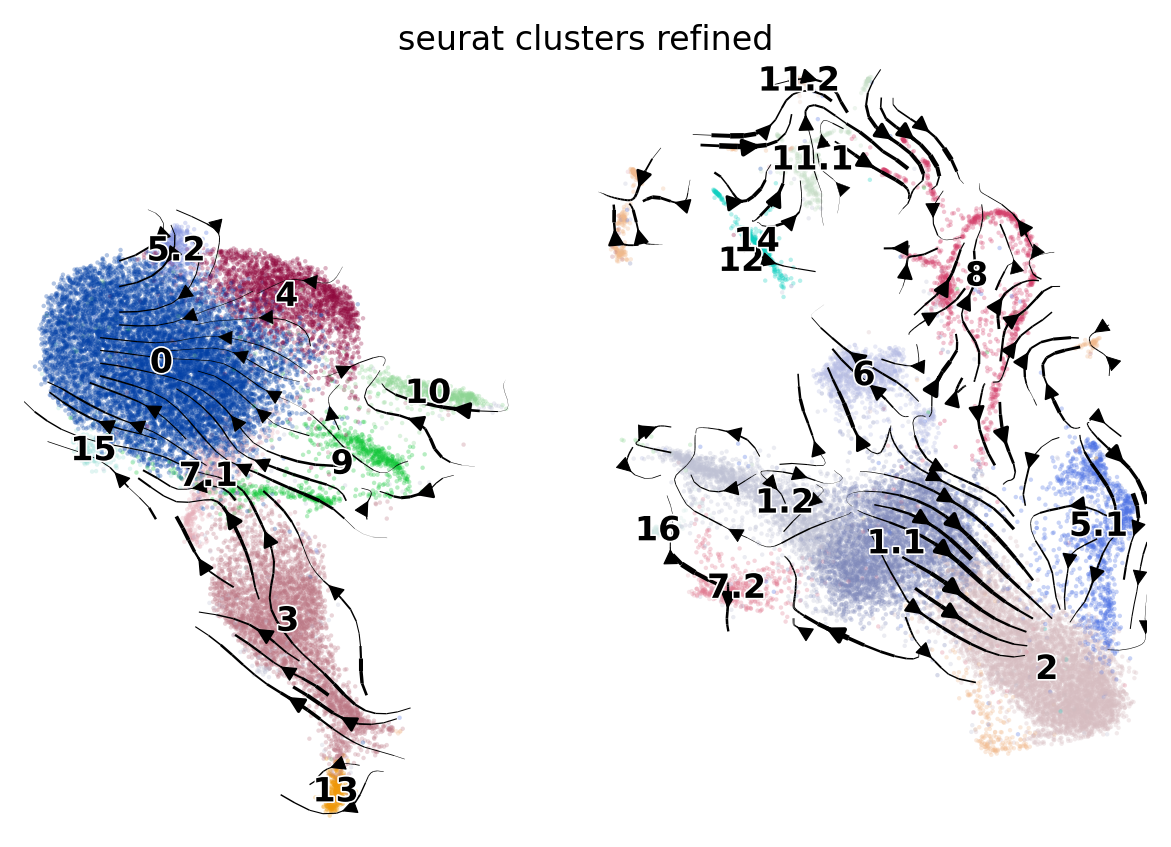

saving figure to file ./figures/scvelo_Velocity_grid_allCD8_samples.svg


In [39]:
# Ploting velocity vectors UMAP figure
%matplotlib inline
scv.pl.velocity_embedding_stream(adata, basis='X_umap',color="seurat_clusters_refined",dpi=120,size=7,save="Velocity_stream_allCD8_samples.svg")
scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="seurat_clusters_refined",save="Velocity_grid_allCD8_samples.svg")

saving figure to file ./figures/scvelo_Velocity_grid_allCD8_samples.svg


In [42]:
## Velocity and highlighting individual samples
#scv.pl.velocity_embedding_stream(adata, basis='X_umap',color="Arm-CD8-Day8_seurat_cluster_refined",dpi=120,size=7,save="Velocity_stream_Arm-CD8-Day8_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Arm-CD8-Day8_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Arm-CD8-Day15_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Arm-CD8-Day35_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Cl13-CD8-Day8_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Cl13-CD8-Day8_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Cl13-CD8-Day35_seurat_cluster_refined")
#scv.pl.velocity_embedding_grid(adata, arrow_length=5, arrow_size=2, basis='X_umap',dpi=120,color="Cl13-CD8-Day35_PD-L1_seurat_cluster_refined")


### [to be done later]


### Section 4:  - Identification of cell that drive velocities observed in clusters
###             - Computing final/root states, cell fate probability (Cellrank)
###             - Speudotime etc.





In [23]:

## PAGA velocity graph
# this is needed due to a current bug - bugfix is coming soon.
#adata.uns['neighbors']['distances'] = adata.obsp['distances']
#adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']
#scv.tl.paga(adata, groups='seurat_clusters')
#df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
#df.style.background_gradient(cmap='Blues').format('{:.2g}')

computing terminal states
    identified 7 regions of root cells and 2 regions of end points 
    finished (0:00:36) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA
    finished (0:00:17) --> added
    'paga/transitions_confidence', connectivities adjacency (adata.uns)
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


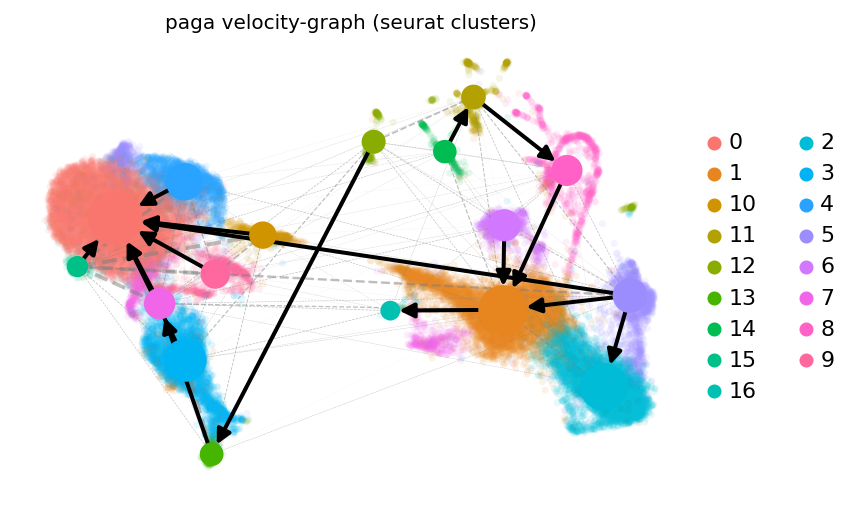

In [24]:
#scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
#min_edge_width=2, node_size_scale=1.5)


In [25]:
## Identifying important genes that explain/contribute to the velocity field accross the clusters

scv.tl.rank_velocity_genes(adata, groupby='seurat_clusters', min_corr=.3)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
#df.to_csv("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_alevin_scvelo_top_genes_explaining_velocity_of_clusters.scv")
df.to_csv("/secondary/projects/mnp/brejnev/rusty/LCMV_Irem/Alevin/CD8_alevin_scvelo_top_genes_explaining_velocity_of_clusters_V2.scv")

ranking velocity genes
    finished (0:00:17) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [26]:
print(df.shape)
df

(71, 17)


0        1        10             11       12      13       14  \
0      Sell    Cenpo   Gm16152        Klhdc8b    Itgb1    Actb     Xist   
1   Gm16152     Pogk  Aldh16a1           Xist   Zbtb26    Xist  Slc7a11   
2      Tsix    Itgb1    Zfp524  9130221H12Rik  Klhdc8b   Sp100    Rps19   
3     Itgb2    Cox17     Actn1          Brca2     Xist   Letm2    Ripk1   
4      Ccl5    Tmcc1     Klrc1        Slc7a11    Rps19  Chaf1a   Cdkn1b   
..      ...      ...       ...            ...      ...     ...      ...   
66    Itgb1  Rarres2      Tsix        Gm16152     Il7r   Tmcc1  Gm47283   
67    Ypel1     Tsix       Spn       B3galnt2    Myef2    Tia1    Cebpd   
68  Slc7a11     Actb     Mirt1          Myef2     Tsix    Hps3  Gm16152   
69   Zeb2os    Krit1   Fam204a          Actg1    Actg1  Zbtb7a    Letm2   
70     Pogk     Sell   Gm12999          Letm2     Ubn2   Itgb1     Tet2   

         15       16              2        3              4        5        6  \
0      Sell    Itga4        Slc7a11    Sp100           Pfn1     Brd9   Cdkn1b   
1   Gm16152     Lsp1          Tmcc1     Lef1           Tsix   Mindy1   Mindy1   
2     Actn1    Cebpd         Zeb2os   Gimap4        Gm16152  Slc7a11    Ypel1   
3      Tsix  Gm16152          Cebpd  Gm16152  4833407H14Rik     Lsp1    Brca2   
4     Itgb2    Itgb1          Ypel1    Itgb2           Xist  Bcdin3d  Klhdc8b   
..      ...      ...            ...      ...            ...      ...      ...   
66    Ypel1  Rarres2           Sell     Hps3         Zeb2os  Zfp518a     Tsix   
67    Tmcc1     Actb           Ccl5    Ahnak        Gm47766  Fam204a  Zfp36l1   
68   Zeb2os    Ahnak  4833407H14Rik    Ypel1          Itgb1    Myef2  Gm16152   
69    Cenpo    Klrc1          Itgb2    Letm2        Gm17122  Gm42846    Actn1   
70     Pogk     Tsix        Gm16152    Tmcc1          Cox17    Actg1    Itgb2   

                7        8              9  
0        Aldh16a1   Cdkn1b  4833407H14Rik  
1            Il7r     Brd9       Aldh16a1  
2            Pfn1   Mindy1         Cdkn1b  
3            Tsix     Ccr5           Ccl5  
4   4833407H14Rik    Ahnak          Itgb2  
..            ...      ...            ...  
66          Casp1  Zfp36l1        Il18rap  
67          Cenpo  Gm16152          Itgb1  
68          Sp100   Gimap4          Krit1  
69           Actb    Actg1       Rab3gap2  
70         Gimap4    Letm2        Zfp518a  

[71 rows x 17 columns]

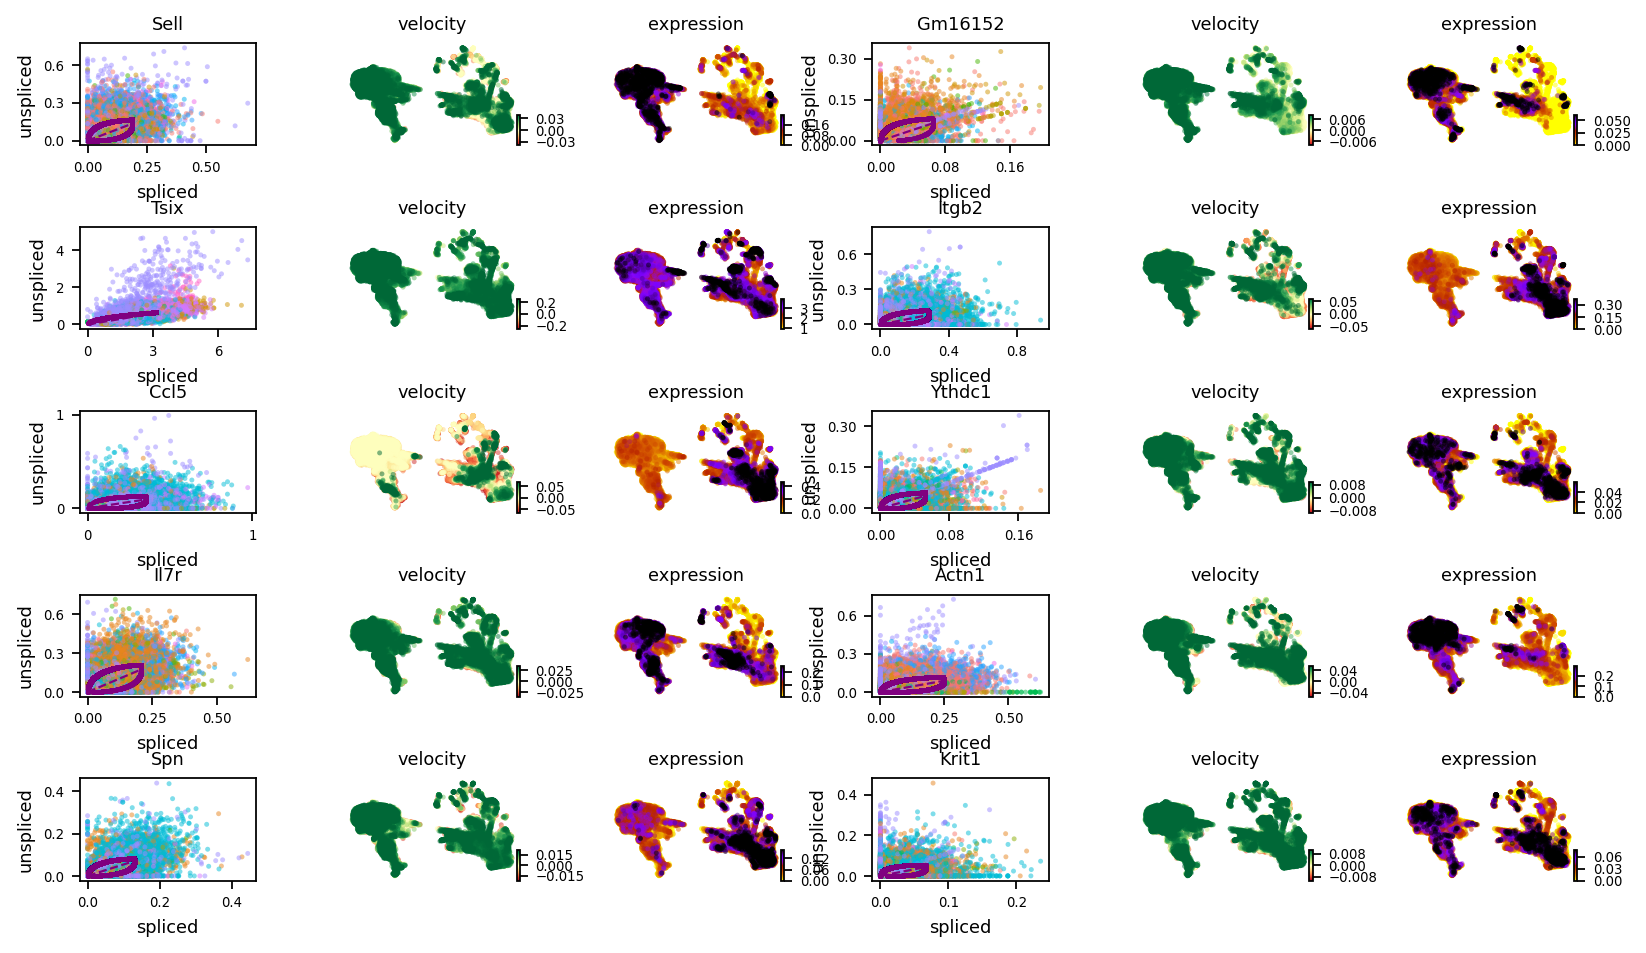

'\nkwargs = dict(frameon=False, size=10, linewidth=1.2,color="seurat_clusters")#, add_outline=\'0, 1, 6\')\nscv.pl.scatter(adata, df[\'0\'][:5], ylabel=\'cluster 0, Naive\', **kwargs)\nscv.pl.scatter(adata, df[\'1\'][:5], ylabel=\'cluster 1, Effector\', **kwargs)\n'

In [32]:

#Explore the velocity of top 10 gene in 
scv.pl.velocity(adata, df['0'][:10],size=20, ncols=2, dpi=200,color="seurat_clusters")

'''
kwargs = dict(frameon=False, size=10, linewidth=1.2,color="seurat_clusters")#, add_outline='0, 1, 6')
scv.pl.scatter(adata, df['0'][:5], ylabel='cluster 0, Naive', **kwargs)
scv.pl.scatter(adata, df['1'][:5], ylabel='cluster 1, Effector', **kwargs)
'''

computing terminal states
    identified 7 regions of root cells and 2 regions of end points 
    finished (0:00:36) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


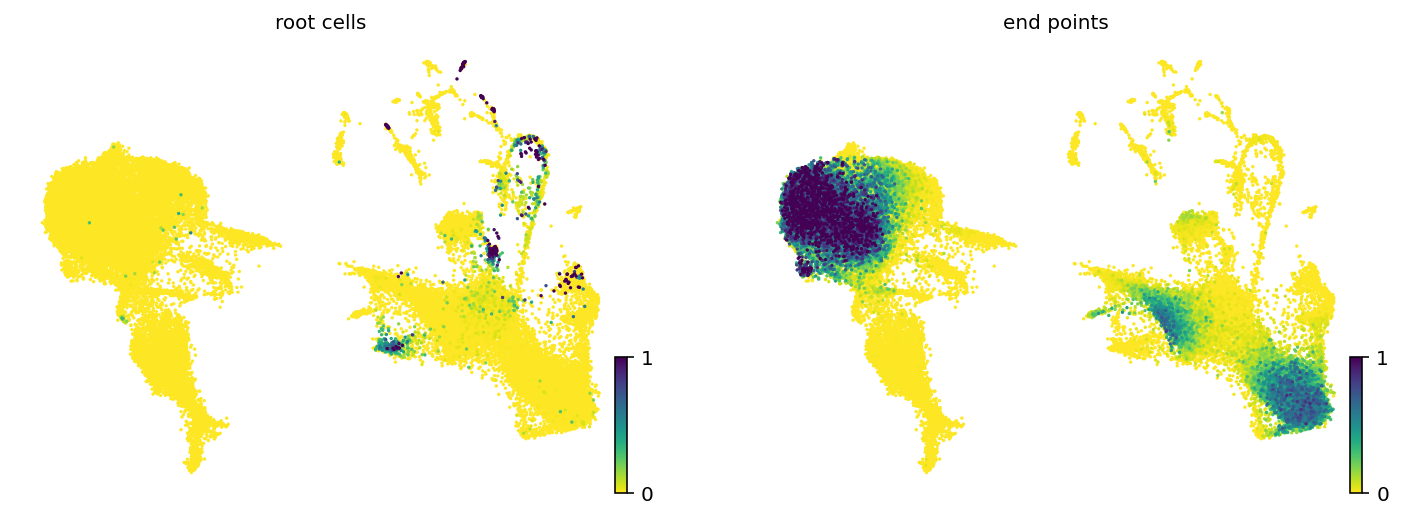

In [28]:
## Computes terminal states (root and end points).
 # The end points and root cells are obtained as stationary states of the velocity-inferred transition matrix and its
 # transposed, respectively, which is given by left eigenvectors corresponding to an eigenvalue of 1, i.e.

scv.tl.terminal_states(adata)
scv.pl.scatter(adata, color=['root_cells', 'end_points'])

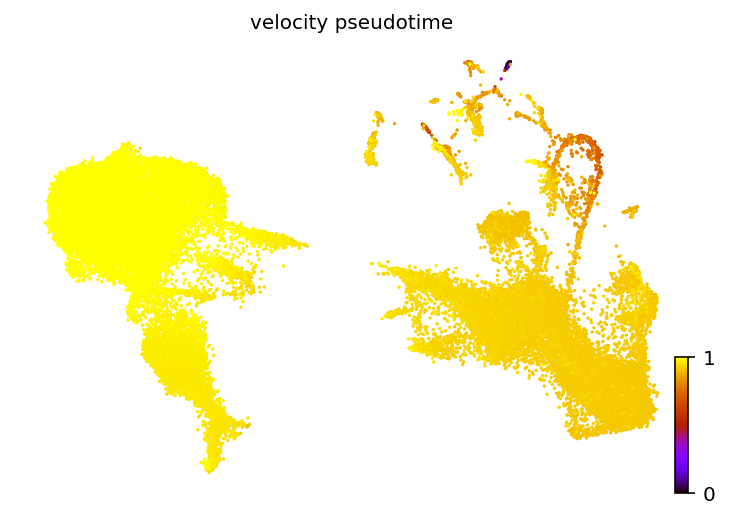

In [33]:
## Computes a pseudotime based on the velocity graph.
 # Velocity pseudotime is a random-walk based distance measures on the velocity graph. After computing a distribution
 # over root cells obtained from the velocity-inferred transition matrix, it measures the average number
 # of steps it takes to reach a cell after start walking from one of the root cells. Contrarily to diffusion pseudotime,
 # it implicitly infers the root cells and is based on the directed velocity graph instead of the similarity-based
 # diffusion kernel.

scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', color_map='gnuplot')

In [ ]:
## Computes velocity clusters via louvain on velocities.

#! scv.tl.velocity_clusters(adata)
#!  scv.pl.scatter(adata, color='velocity_clusters')

In [34]:
adata

AnnData object with n_obs × n_vars = 39773 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'housekeeping_gene', 'nCount_RNA.log2', 'outlier', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'integrated_snn_res.0.5', 'ident', 'orig.identF', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'seurat_clusters_colors', 'paga', 'seurat_clusters_sizes', 'rank_velocity_genes'
    obsm: 'X_pca'

In [41]:
#%%R
#top 10 gene in 
#scv.pl.velocity(adata, df['0'][:4],size=15, ncols=2, dpi=200)

#kwargs = dict(frameon=False, size=10, linewidth=1.2)
#scv.pl.scatter(adata, df['0'][:5], ylabel='cluster 0, Naive', **kwargs)
#scv.pl.scatter(adata, df['1'][:5], ylabel='cluster 1, Effector', **kwargs)

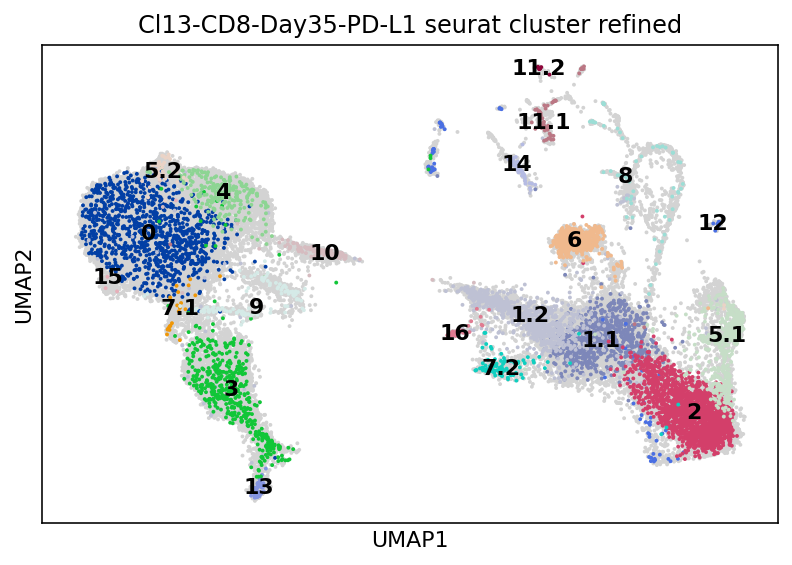

In [46]:
sc.pl.scatter(adata,basis="umap",size=15, alpha=1,color="Cl13-CD8-Day35-PD-L1_seurat_cluster_refined",legend_loc='on data',save="Cl13-CD8-Day35-PD-L1_seurat_cluster_refined.svg")